In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.datasets import load_breast_cancer


In [3]:
data = load_breast_cancer()

In [4]:
x,y = data.data, data.target

In [5]:
df = pd.DataFrame(x, columns=data.feature_names)
df["target"] = data.target
df["target"].replace(0,data.target_names[0], inplace=True)
df["target"].replace(1,data.target_names[1], inplace=True)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train_,x_test_, y_train, y_test= train_test_split(
    x,
    y,
    test_size=0.33,
    random_state=42,
    shuffle=True,
    stratify=y)

In [8]:
# from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.preprocessing import MinMaxScaler as Scaler

In [9]:
sc = Scaler()
x_train = sc.fit_transform(x_train_)
x_test = sc.transform(x_test_)

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [12]:
knn_ = KNeighborsClassifier()

In [13]:
parameters = {'n_neighbors':list(range(2,20))}

clf = GridSearchCV(knn_, parameters)
clf.fit(x_train, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19]})

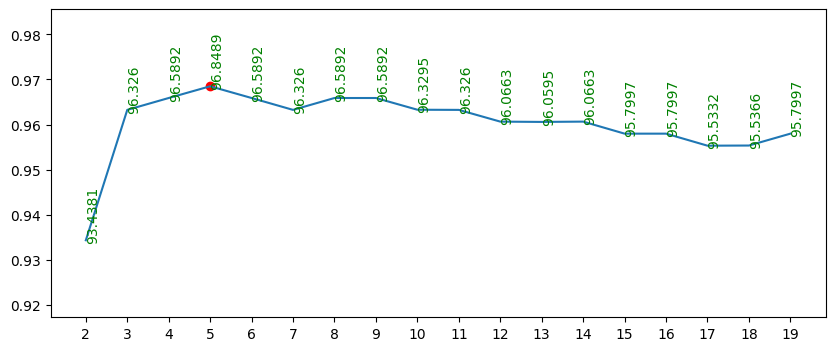

In [14]:
plt.figure(figsize=(10,4))
yy = clf.cv_results_["mean_test_score"]
xx = parameters["n_neighbors"]
plt.plot(xx,yy)
plt.xticks(xx)
plt.scatter(xx[yy.argmax()], max(yy),c ="red")
for xxx,yyy in zip(xx,yy):
    
    plt.text(xxx,yyy,s=round(yyy*100,4),c ="green",rotation=90)
plt.margins(y=0.5)

In [15]:
def print_str(names,values):
    for name, value in zip(names,values):
        if type(value) is str:
            print(f"{name}: {value}")
        else:
            print(f"{name}: {value:.4}")

In [16]:
print_str(["best_params_","best_score_"],[str(clf.best_params_),clf.best_score_])

best_params_: {'n_neighbors': 5}
best_score_: 0.9685


In [17]:
from sklearn.model_selection import cross_val_score


In [18]:
def model(method, x_train,y_train,x_test,y_test):
    if method=="knn":
        clf = KNeighborsClassifier(n_neighbors=5)
        model_ = KNeighborsClassifier(n_neighbors=5)
    elif method=="gnb":
        clf = GaussianNB()
        model_ = GaussianNB()
    else:
        return None
    model_.fit(x_train,y_train)
    scores = cross_val_score(clf, x_train,y_train, cv=10, scoring="accuracy")
    print_str(["score train set", "score test set","mean score kfold"]
              ,[model_.score(x_train,y_train),model_.score(x_test,y_test),np.mean(scores)])
    
    plt.plot(list(range(1,11)),scores, label="score")
    plt.scatter(list(range(1,11)),scores,c="red")
    plt.xticks(list(range(1,11)))
    plt.legend()
    plt.show()
    return model_,scores
    

score train set: 0.9764
score test set: 0.9734
mean score kfold: 0.9685


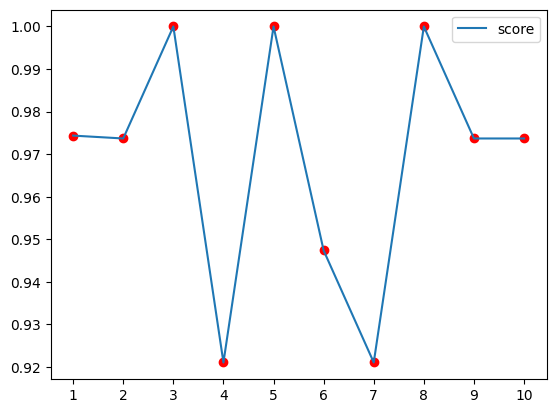

score train set: 0.9423
score test set: 0.9415
mean score kfold: 0.9369


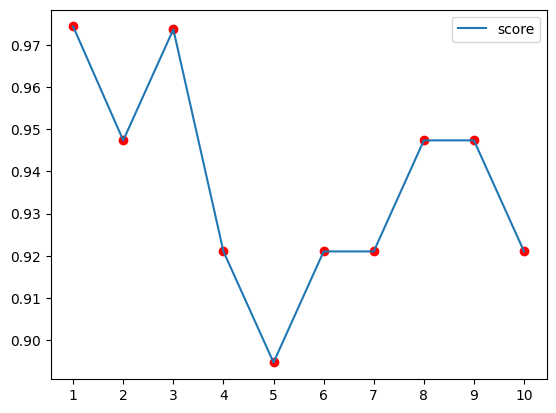

In [19]:
knn,scores_knn = model(method = "knn", x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)
gnb,scores_gnb = model(method = "gnb", x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)

<div dir="rtl" style="font-size:20px; text-align:right; font-family:B Koodak">
    یکی از روش های انتخاب پارامتر های مدل استفاده از GridSearchCV است
    در این روش با استفاده از یک دیکشنری تمام مدل را برای تمام فضای حالت آموزش میدهد و پارامتر های متناظر با بهترین نتیجه را خروجی میده
    
</div>

In [20]:
def feature_selection(model_name,x_train,y_train):
    
    best_score = 0
    cols = list()
    while True:

        last_score = best_score
        best_index = None
        for col in  range(x_train.shape[1]):
            if col in cols:
                continue
            if model_name == "knn":
                       
                model = KNeighborsClassifier(n_neighbors=5)
            elif model_name == "gnb":
                model = GaussianNB()
            else:
                return None, None
            
            model.fit(x_train[:,cols+[col]],y_train)
            score = model.score(x_train[:,cols+[col]],y_train)
            if best_score<score:
                best_index = col
                best_score = score
        if last_score == best_score :
            break
        cols.append(best_index)
        print(cols,round(best_score,5))
        
    return cols,best_score

In [21]:
cols_index_by_knn, _ = feature_selection("knn",x_train,y_train)
print(*data.feature_names[cols_index_by_knn], sep=", ")

[23] 0.93438
[23, 24] 0.97638
[23, 24, 20] 0.98163
[23, 24, 20, 21] 0.98425
worst area, worst smoothness, worst radius, worst texture


In [22]:
cols_index_by_gnb, _ = feature_selection("gnb",x_train,y_train)
print(*data.feature_names[cols_index_by_gnb], sep=", ")

[22] 0.92388
[22, 24] 0.95801
[22, 24, 21] 0.98163
worst perimeter, worst smoothness, worst texture


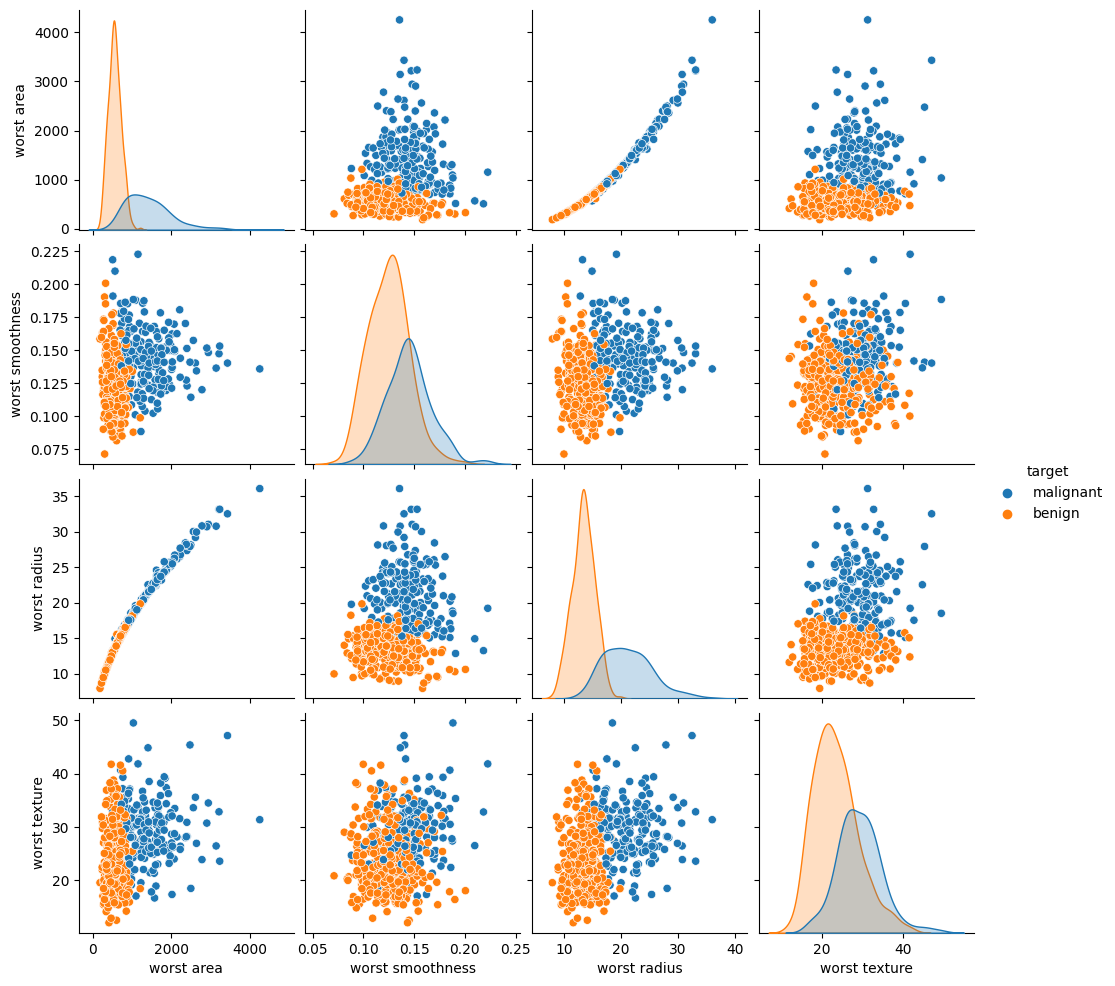

In [23]:
sns.pairplot(df[list(data.feature_names[cols_index_by_knn])+["target"]], hue='target')
plt.show()

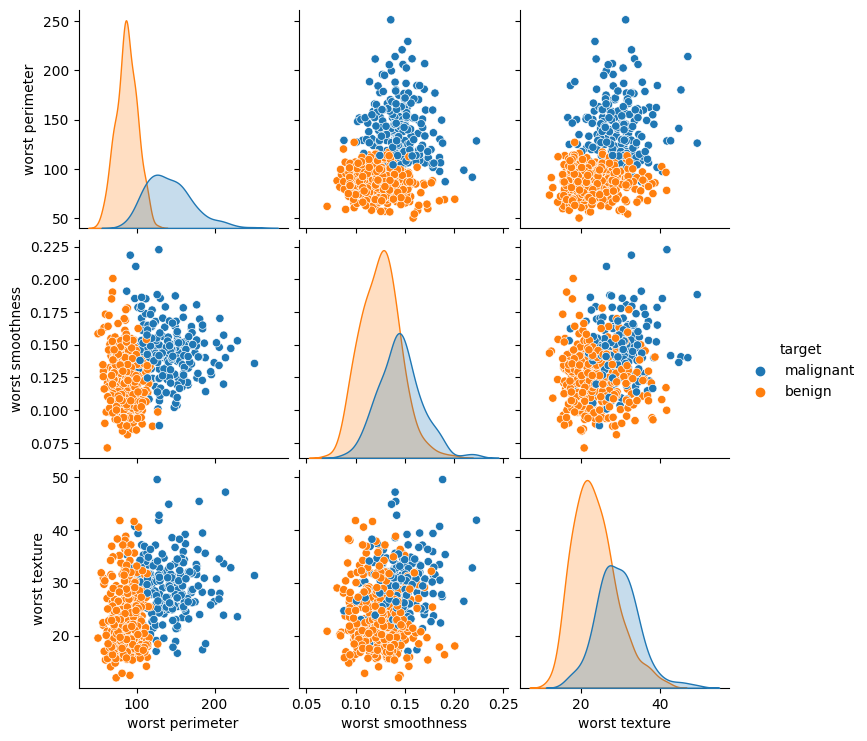

In [24]:
sns.pairplot(df[list(data.feature_names[cols_index_by_gnb])+["target"]], hue='target')
plt.show()

<div dir="rtl" style="font-size:20px; text-align:right; font-family:B Koodak">
  در این روش ساده میتوان ستون ها را به مدل اضافه کرد و هر بار مدل را بر اساس ان ستون ها اموزش داد و در هر مرحله ستونی که باعث افزایش بیشتر دقت مدل میشود را به لیستی ستون های انتخابی اضافه میکنیم این کار را تا زمانی ادامه میدهیم 
   که با افزودن ستون به مجموعه ستون های انتخابی باعث افزایش دقت نشود
     <br>
    در مدل نزدیک ترین همسایه با انتخاب ستون های 23, 24, 20, 21  که متناظر با ویژگی های <br> 
    'worst area', 'worst smoothness', 'worst radius', 'worst texture'
    <br>
     است و در مدل شبکه بیز با انتخاب 
     ستون های 22, 24, 21  که متناظر با ویژگی های <br> 
    'worst perimeter', 'worst smoothness', 'worst texture'
    <br>
    است بهترین نتایج را حاصل میشود .
</div>

In [25]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

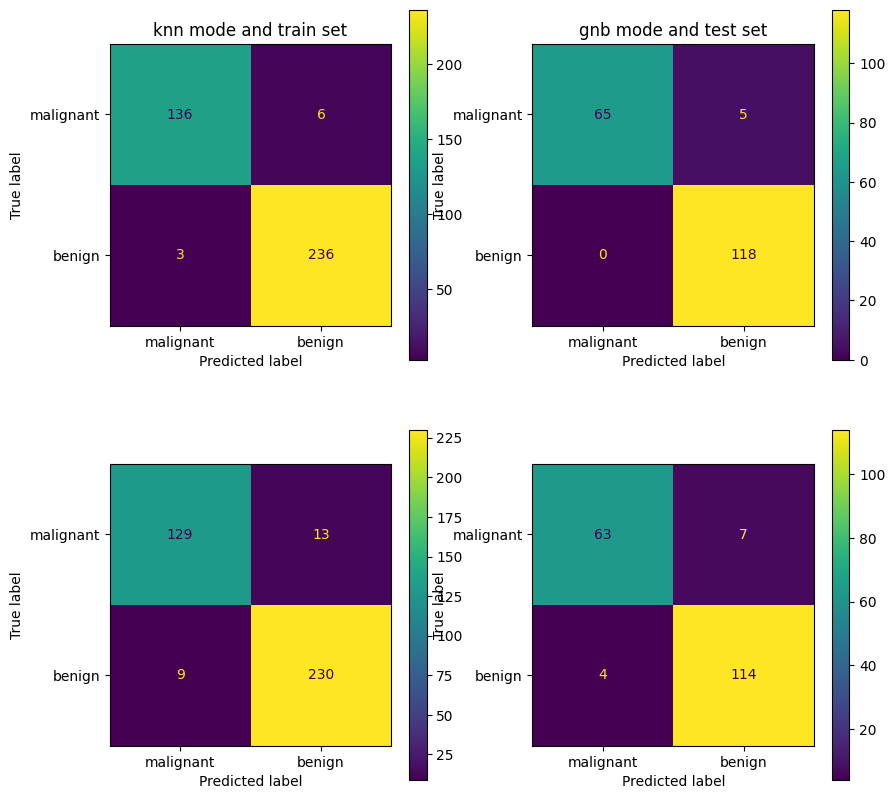

In [26]:
fig , ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))

ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_train, knn.predict(x_train)),
    display_labels = data.target_names).plot(ax=ax1)
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, knn.predict(x_test)),
    display_labels = data.target_names).plot(ax=ax2)
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_train, gnb.predict(x_train)),
    display_labels = data.target_names).plot(ax=ax3)
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, gnb.predict(x_test)),
    display_labels = data.target_names).plot(ax=ax4)
ax1.set_title("knn mode and train set")
ax2.set_title("knn mode and test set")
ax2.set_title("gnb mode and train set")
ax2.set_title("gnb mode and test set")
plt.show()


In [27]:
from sklearn.metrics import classification_report

In [28]:
print("knn mode and train set")
print(classification_report(y_train, knn.predict(x_train),target_names= data.target_names))
print("knn mode and test set")
print(classification_report(y_test, knn.predict(x_test),target_names= data.target_names))
print("gnb mode and train set")
print(classification_report(y_train, gnb.predict(x_train),target_names= data.target_names))
print("gnb mode and test set")
print(classification_report(y_test, gnb.predict(x_test),target_names= data.target_names))

knn mode and train set
              precision    recall  f1-score   support

   malignant       0.98      0.96      0.97       142
      benign       0.98      0.99      0.98       239

    accuracy                           0.98       381
   macro avg       0.98      0.97      0.97       381
weighted avg       0.98      0.98      0.98       381

knn mode and test set
              precision    recall  f1-score   support

   malignant       1.00      0.93      0.96        70
      benign       0.96      1.00      0.98       118

    accuracy                           0.97       188
   macro avg       0.98      0.96      0.97       188
weighted avg       0.97      0.97      0.97       188

gnb mode and train set
              precision    recall  f1-score   support

   malignant       0.93      0.91      0.92       142
      benign       0.95      0.96      0.95       239

    accuracy                           0.94       381
   macro avg       0.94      0.94      0.94       381
weight

<div dir="rtl" style="font-size:20px; text-align:right; font-family:B Koodak">
    با در نظر گرفتن فرمول های معیار های ارزیابی و این که تشخیص صحیح نوع سرطان میتواند از مرگ بیمار جلوگیری کند پس با این وجود اگر مدل را بر اساس معیار ارزیابی 
    Recall
    ارزیابی بشود شاید بهتر باشد چون در این نوع ارزیابی درستی طبقه بندی توسط مدل بررسی میشود و از انجایی که میتواند اموزش بر اساس این معیار ارزیابی باعث تغییرات در سایر معیار های ارزیابی شود میتوان از 
    F1-Score
    که میانگین هارمونیک از معیار ارزیابی 
    Recall و 
    Precision 
    است استفاده کرد 
</div>

<div dir="rtl" style="font-size:20px; text-align:right; font-family:B Koodak">
   برای بالا بردن دقت مدل از مقیاس بندی داده استفاده شده است.
   
</div>